# Workflow

In [1]:
import numpy as np
import sys

sys.path.append('../hydra_tod/')

# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator

In [2]:
# Load the simulation results
import pickle
from simulation import TODSimulation

with open('tod_simulation_single.pkl', 'rb') as f:
    tod_sim = pickle.load(f)


In [3]:
sky_params = tod_sim.sky_params
nd_rec_params = tod_sim.nd_rec_params
gain_params_setting = tod_sim.gain_params_setting
calibration_indices = tod_sim.calibration_1_indice
alpha = tod_sim.alpha

TOD_setting = tod_sim.TOD_setting
t_list = tod_sim.t_list
gain_proj = tod_sim.gain_proj
Tsky_operator_setting = tod_sim.Tsky_operator_setting
nd_rec_operator = tod_sim.nd_rec_operator

logfc = tod_sim.logfc

# Additional variables needed for the analysis
pixel_indices = tod_sim.pixel_indices
nside = tod_sim.nside
f0 = tod_sim.f0
T_ndiode = tod_sim.T_ndiode
rec_params = tod_sim.rec_params
logf0 = tod_sim.logf0  # Convert to list format as expected later

In [4]:
# init_Tsys_params = np.hstack([sky_params, nd_rec_params])
init_noise_params_list = [[logf0, alpha]]
init_Tloc_params_list = [nd_rec_params]
init_Tsky_params = sky_params


prior_std_frac = 0.1

gain_prior_mean = gain_params_setting
gain_prior_cov_inv = 1.0 / (prior_std_frac * gain_params_setting)**2  # Prior STD ~10%
gain_prior_cov_inv[gain_prior_cov_inv > 100] = 100
# gain_prior_cov_inv[0] = 2.51 # DC mode: Prior STD ~10%

Tsky_prior_cov_inv = 1.0 / (prior_std_frac * sky_params)**2
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = 1.0 / (nd_rec_params)**2  # Prior STD ~100%
aux[0] = 10.0
aux[1] = 1.0

Trec_prior_cov_inv_list = [aux] # Effectively no prior


In [ ]:
# Import the FlickerCorrEmulator class first
from full_Gibbs_sampler import TOD_Gibbs_sampler

Tsys_samples, all_gain_samples, all_noise_samples= \
    TOD_Gibbs_sampler(
        [TOD_setting],
        [t_list],
        [gain_proj],
        [Tsky_operator_setting],
        [nd_rec_operator],
        init_Tsky_params,
        init_Tloc_params_list,
        init_noise_params_list,
        [logfc],
        wnoise_var=2.5e-6,
        Tsky_prior_cov_inv=Tsky_prior_cov_inv,
        Tsky_prior_mean=sky_params,
        local_Tloc_prior_cov_inv_list=Trec_prior_cov_inv_list,
        local_Tloc_prior_mean_list=[nd_rec_params],
        local_gain_prior_cov_inv_list=[gain_prior_cov_inv],
        local_gain_prior_mean_list=[gain_prior_mean],
        # local_noise_prior_func_list=[log_prior_noise],
        joint_Tsys_sampling=True,
        smooth_gain_model="linear",
        noise_sampler_type="emcee",
        noise_Jeffreys_prior=False,
        n_samples=2000,
        tol=1e-20,
        debug=True,)

In [ ]:
np.save("outputs/GS1/Tsys_samples_linearG.npy", Tsys_samples)
np.save("outputs/GS1/gain_samples_linearG.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GS1/noise_samples_linearG.npy", np.concatenate(all_noise_samples, axis=0))


In [5]:
Tsys_samples = np.load("outputs/GS1/Tsys_samples_linearG.npy")
gain_samples = np.load("outputs/GS1/gain_samples_linearG.npy")
noise_samples = np.load("outputs/GS1/noise_samples_linearG.npy")

In [6]:
param_names_compact = [
    r'$p_{{\rm g},0}$', r'$p_{{\rm g},1}$', r'$p_{{\rm g},2}$', r'$p_{{\rm g},3}$',  # 4 gain parameters
    r'$p_{{\rm loc},0}$', r'$p_{{\rm loc},1}$', r'$p_{{\rm loc},2}$', r'$p_{{\rm loc},3}$', r'$p_{{\rm loc},4}$',  # 5 receiver parameters
    r'$\log_{10} f_0$', r'$\alpha$'  # 2 noise parameters
]

### a. Trace plots

In [7]:
from MCMC_diagnostics import diagnostics

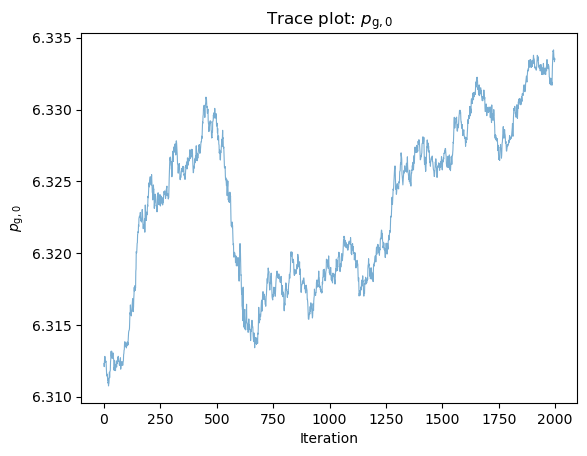

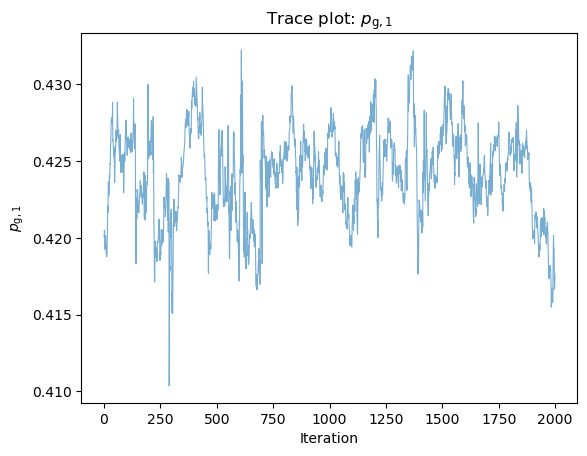

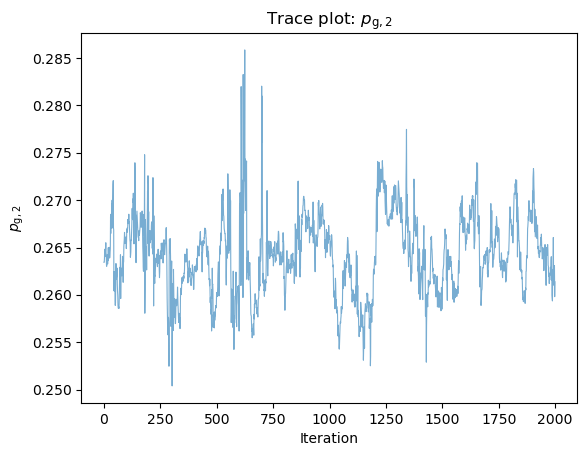

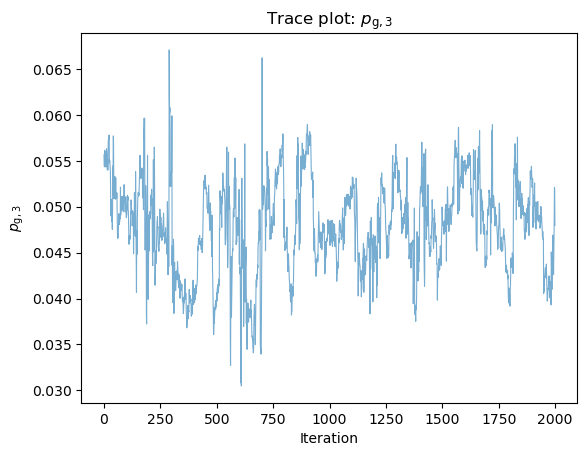

{'$p_{{\\rm g},0}$': {'ESS_min': 6.164774831662228,
  'ESS_median': 6.164774831662228,
  'Rhat_split': 1.29946058783349},
 '$p_{{\\rm g},1}$': {'ESS_min': 43.59823217853457,
  'ESS_median': 43.59823217853457,
  'Rhat_split': 1.0115519313193495},
 '$p_{{\\rm g},2}$': {'ESS_min': 46.57961677962279,
  'ESS_median': 46.57961677962279,
  'Rhat_split': 0.9997342237111867},
 '$p_{{\\rm g},3}$': {'ESS_min': 53.56877542679346,
  'ESS_median': 53.56877542679346,
  'Rhat_split': 1.0082927053462833}}

In [8]:
diagnostics(gain_samples, param_names=param_names_compact[:4], max_plots=5)

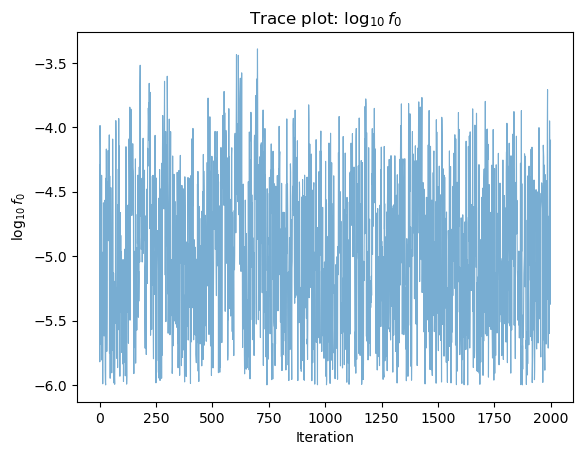

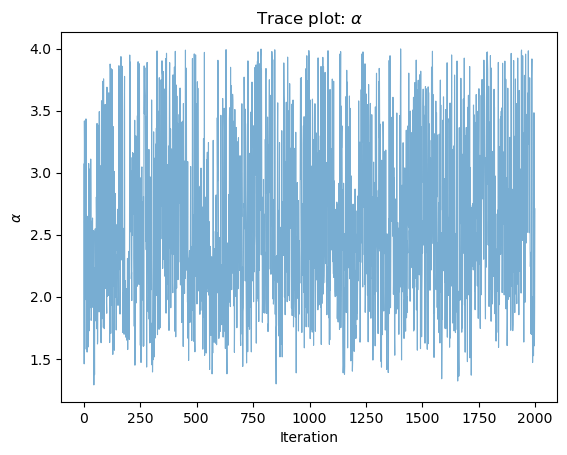

{'$\\log_{10} f_0$': {'ESS_min': 492.14197537120276,
  'ESS_median': 492.14197537120276,
  'Rhat_split': 1.0043358101204878},
 '$\\alpha$': {'ESS_min': 588.5546430376766,
  'ESS_median': 588.5546430376766,
  'Rhat_split': 1.0009367272508956}}

In [9]:
diagnostics(noise_samples, param_names=param_names_compact[9:], max_plots=5)

In [8]:
from visualisation import plot_residual_histogram, view_patch_map, gnomview_patch
from analysis import explore_posterior_joint_Tsys


292


All pixels - Mean: 0.0022, Std: 0.1530, RMS: 0.1531
All pixels - 16th-84th percentile: [-0.0634, 0.1032]
Internal pixels - Mean: 0.0052, Std: 0.1447, RMS: 0.1448
Internal pixels - 16th-84th percentile: [-0.0516, 0.0956]
Plot saved to: figures/new/GS1_mean_res.pdf


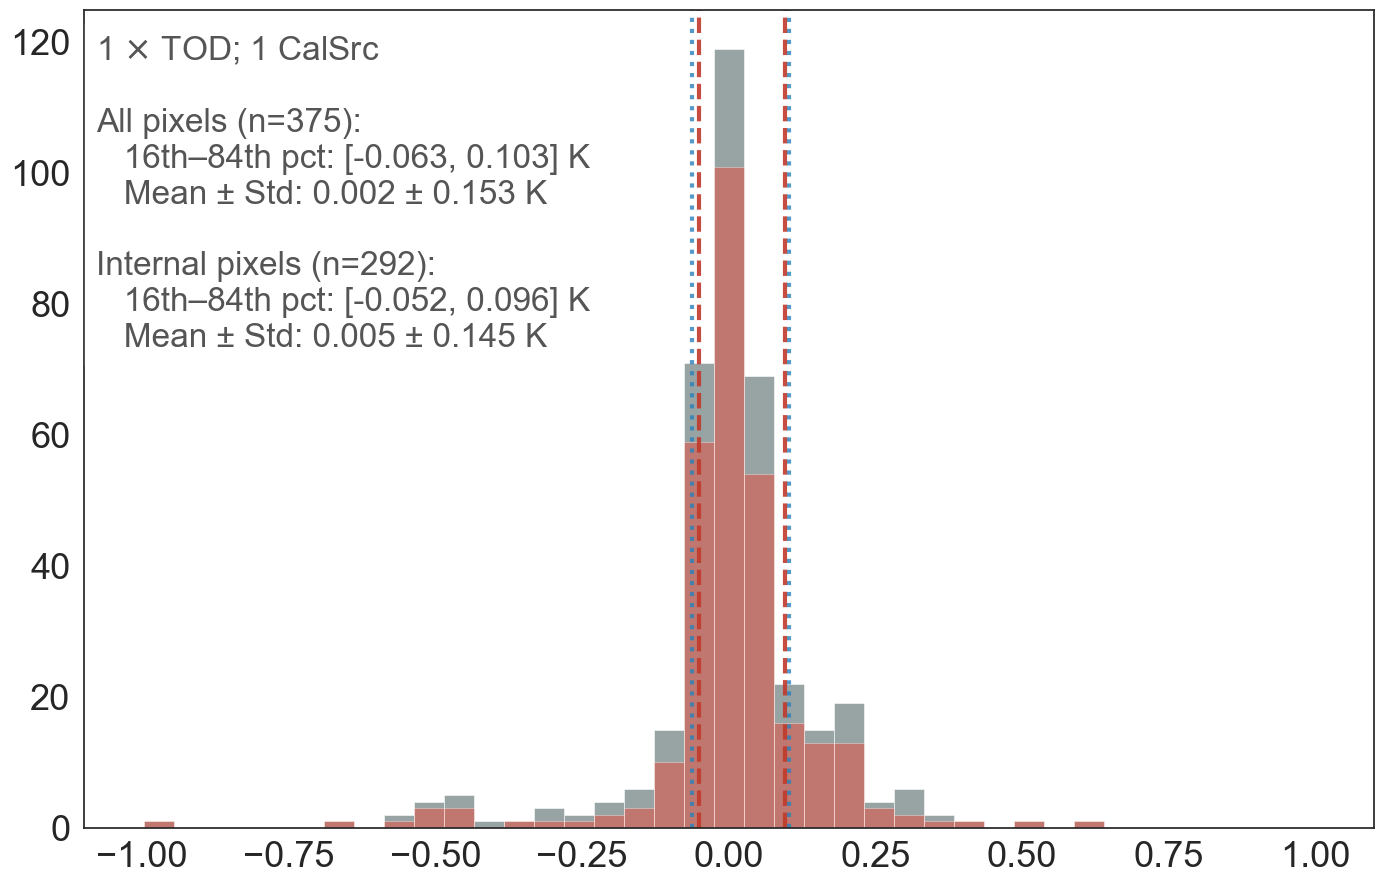

All pixels - Mean: 0.0025, Std: 0.1531, RMS: 0.1531
All pixels - 16th-84th percentile: [-0.0630, 0.1010]
Internal pixels - Mean: 0.0055, Std: 0.1451, RMS: 0.1452
Internal pixels - 16th-84th percentile: [-0.0500, 0.0921]
Plot saved to: figures/new/GS1_median_res.pdf


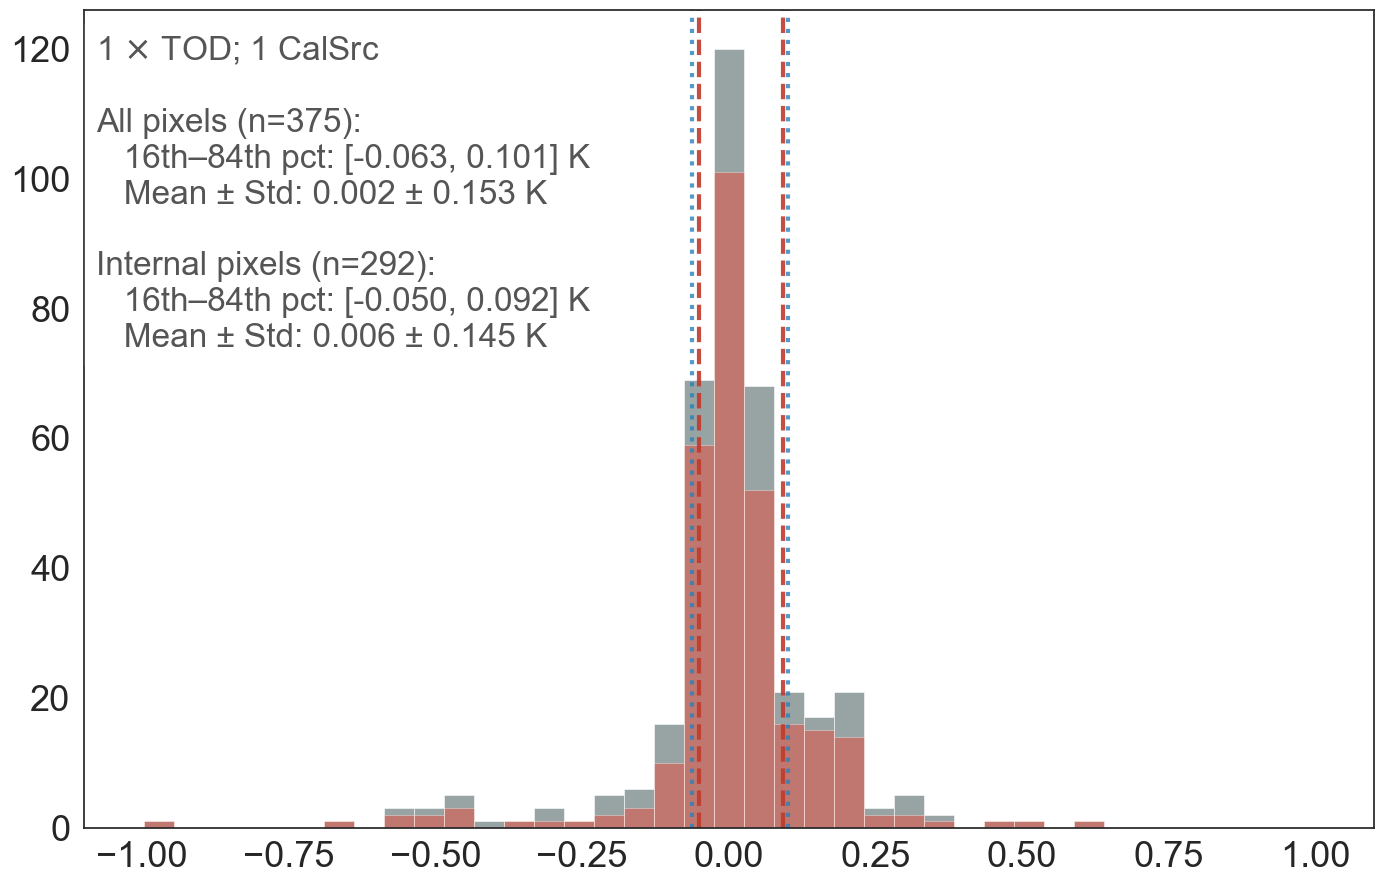

/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be in

{'mean': (array([ 7.96320029,  8.19029961,  7.66771086,  7.60610235,  8.46545501,
          7.40684428,  6.96315137,  6.91999066,  6.86565453,  7.1145605 ,
          6.15946188,  6.28295175,  5.80775651,  5.89828602,  5.47098063,
          5.20583492,  5.59424474,  5.76946717,  5.72124125,  7.91963554,
          8.01866207,  8.22630898,  8.40354896,  8.05220248,  7.58383781,
          7.0100018 ,  6.28477098,  7.04641987,  6.78013277,  6.45143404,
          6.77668477,  5.98026484,  6.0483761 ,  5.56082413,  5.61898825,
          5.22701754,  5.64923915,  6.03909989,  5.89468629,  8.13600265,
         11.02168417,  8.05456524,  7.88420883,  8.12437612,  7.60689698,
          7.80959536,  7.00408356,  6.83865969,  7.1764495 ,  7.05933793,
          6.58821892,  6.05420025,  5.9477627 ,  5.8946773 ,  6.08605625,
          6.01361478,  5.71725315,  5.76487951,  5.98418453,  8.2736846 ,
          8.10578119,  8.37731917,  8.07424257,  8.32200537,  8.13606383,
          7.49460361,  7.30019

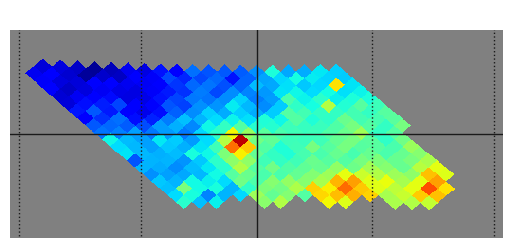

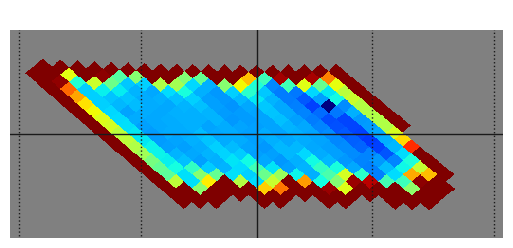

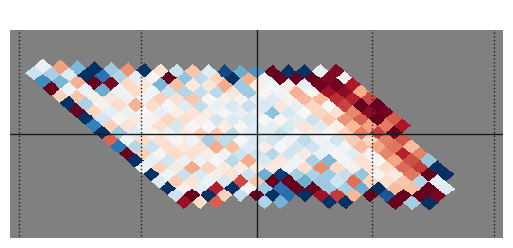

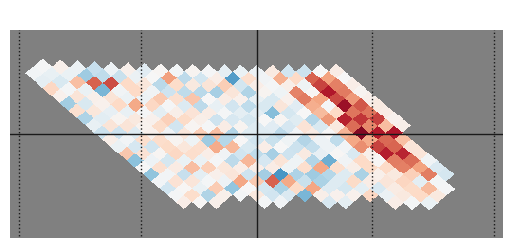

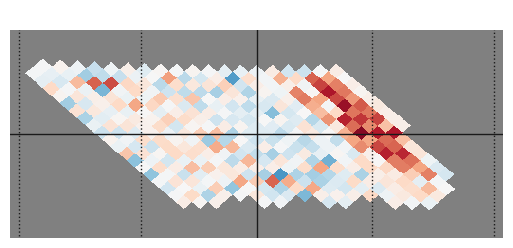

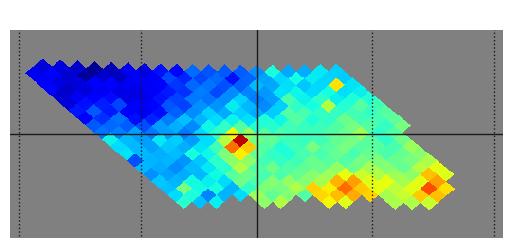

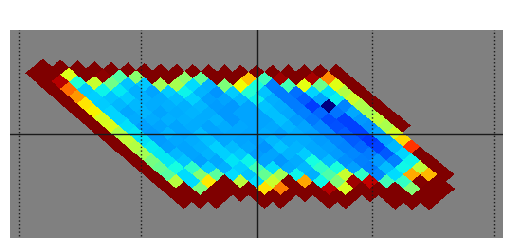

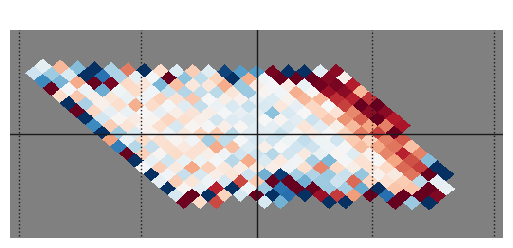

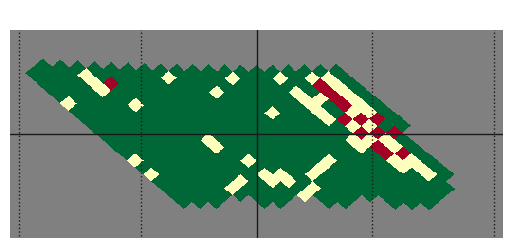

In [9]:
explore_posterior_joint_Tsys(Tsys_samples, 
                             gain_samples, 
                             noise_samples, 
                             sky_params,
                             title_str= r'1 $\times$ TOD; 1 CalSrc',
                             save_path='figures/new/GS1',
                             two_x_TODs=False, 
                             warm_up=0, 
                             cbar=False
                             )
